In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
import os
import matplotlib.pyplot as plt

In [3]:

OUTPUT_DIR = "data/data_outputs_bank"


TARGET = "y"
SYN_MODELS = ["ctgan", "tvae", "copula"]



In [4]:

# Load real data
train_real = pd.read_csv(os.path.join(OUTPUT_DIR, "train_df_bank.csv"))
holdout = pd.read_csv(os.path.join(OUTPUT_DIR, "holdout_df_bank.csv"))

# Load synthetic datasets
datasets = {
    "Real": train_real
}
for model in SYN_MODELS:
    datasets[model.upper()] = pd.read_csv(os.path.join(OUTPUT_DIR, f"synthetic_{model}_bank.csv"))


In [5]:
# Split features and labels
def split_xy(df):
    X = df.drop(columns=[TARGET])
    y = df[TARGET]
    return X, y

X_holdout, y_holdout = split_xy(holdout)


In [6]:
# Process scaled data for logreg training
scaler = StandardScaler()
scaled_datasets = {}
for name, df in datasets.items():
    X, y = split_xy(df)
    X_scaled = scaler.fit_transform(X)
    scaled_datasets[name] = (X_scaled, y)


In [7]:
# Define models to train
MODELS = {
    "LogReg": LogisticRegression(max_iter=500),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42)
}

In [13]:
results = []

for model_name, model in MODELS.items():
    for source_name in datasets:
        if model_name == "LogReg":
            X_train, y_train = scaled_datasets[source_name]
            X_eval = scaler.fit_transform(X_holdout)
        else:
            X_train, y_train = split_xy(datasets[source_name])
            X_eval = X_holdout

        model.fit(X_train, y_train)
        y_pred = model.predict(X_eval)
        y_proba = model.predict_proba(X_eval)[:, 1]

        # 🔍 Count class predictions for Copula only
        if source_name.upper() == "COPULA":
            values, counts = np.unique(y_pred, return_counts=True)
            total = counts.sum()
            for val, count in zip(values, counts):
                print(f"Model: {model_name}, Predicted Class: {val}, Count: {count}, Proportion: {count / total:.4f}")

        # ✅ Append results
        results.append({
            "Model": model_name,
            "Trained_On": source_name,
            "Accuracy": accuracy_score(y_holdout, y_pred),
            "AUC": roc_auc_score(y_holdout, y_proba),
            "F1": f1_score(y_holdout, y_pred),
            "Precision": precision_score(y_holdout, y_pred),
            "Recall": recall_score(y_holdout, y_pred)
        })


/Users/brandon/Documents/projects/synth_data_proj/synth_data_proj_venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/brandon/Documents/projects/synth_data_proj/synth_data_proj_venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/brandon/Documents/projects/synth_data_proj/synth_data_proj_venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/brandon/Documents/projects/synth_data_proj/synth_data_proj_venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/brandon/Documents/projec

Model: LogReg, Predicted Class: 0, Count: 11278, Proportion: 0.9978
Model: LogReg, Predicted Class: 1, Count: 25, Proportion: 0.0022
Model: RandomForest, Predicted Class: 0, Count: 11301, Proportion: 0.9998
Model: RandomForest, Predicted Class: 1, Count: 2, Proportion: 0.0002


In [15]:

# Save results to CSV
results_df = pd.DataFrame(results)
results_df.to_csv(os.path.join(OUTPUT_DIR, "utility_results_bank.csv"), index=False)
print(results_df)

          Model Trained_On  Accuracy       AUC        F1  Precision    Recall
0        LogReg       Real  0.891179  0.871361  0.332972   0.588123  0.232224
1        LogReg      CTGAN  0.884367  0.852049  0.370120   0.509960  0.290469
2        LogReg       TVAE  0.877820  0.866605  0.467412   0.476790  0.458396
3        LogReg     COPULA  0.883128  0.852238  0.019302   0.520000  0.009834
4  RandomForest       Real  0.905423  0.924246  0.507600   0.648999  0.416793
5  RandomForest      CTGAN  0.894541  0.871479  0.425265   0.586436  0.333585
6  RandomForest       TVAE  0.859772  0.865916  0.515439   0.432530  0.637670
7  RandomForest     COPULA  0.882863  0.776475  0.000000   0.000000  0.000000


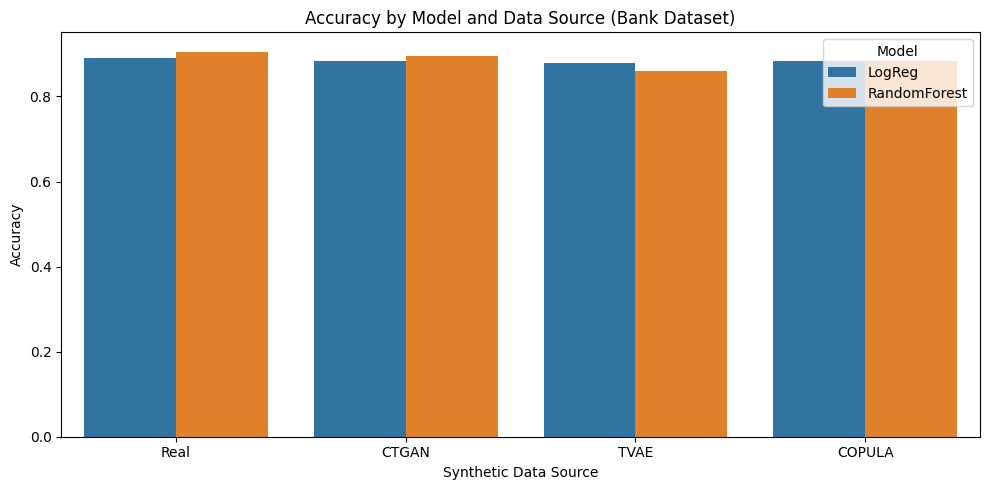

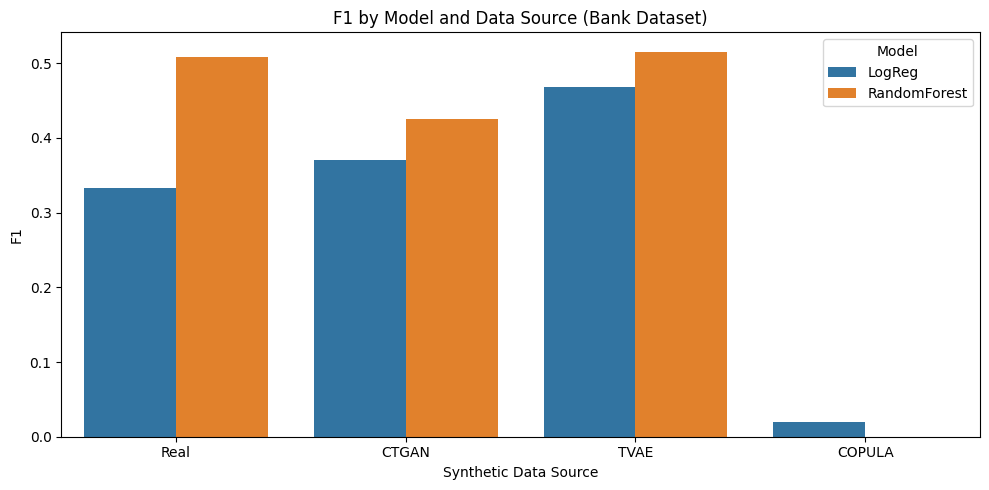

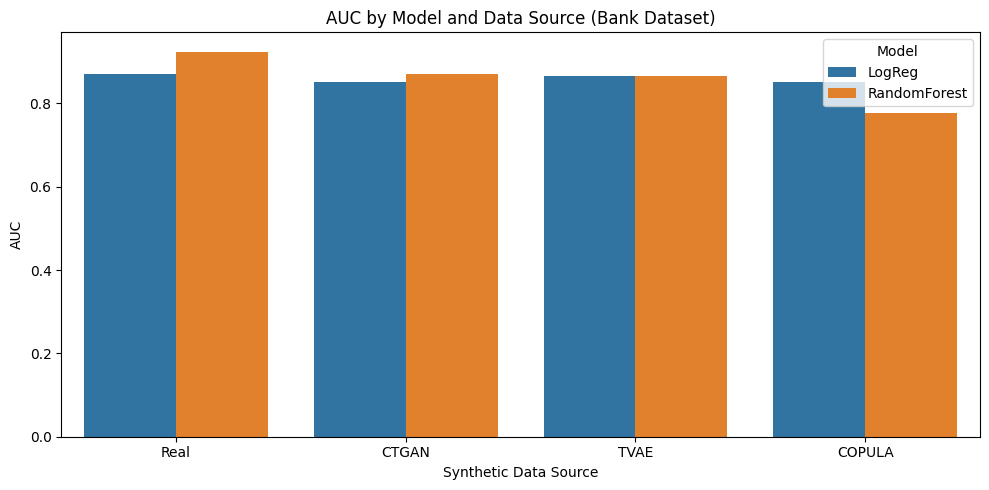

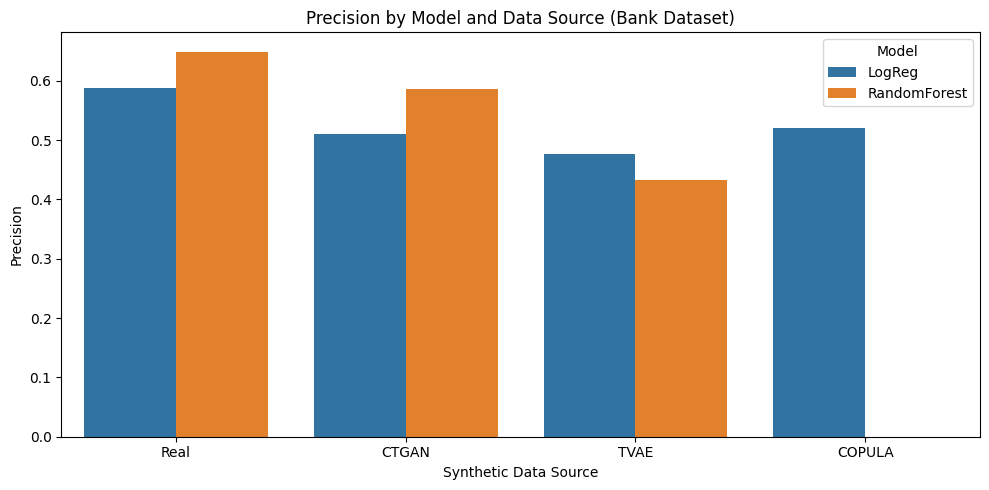

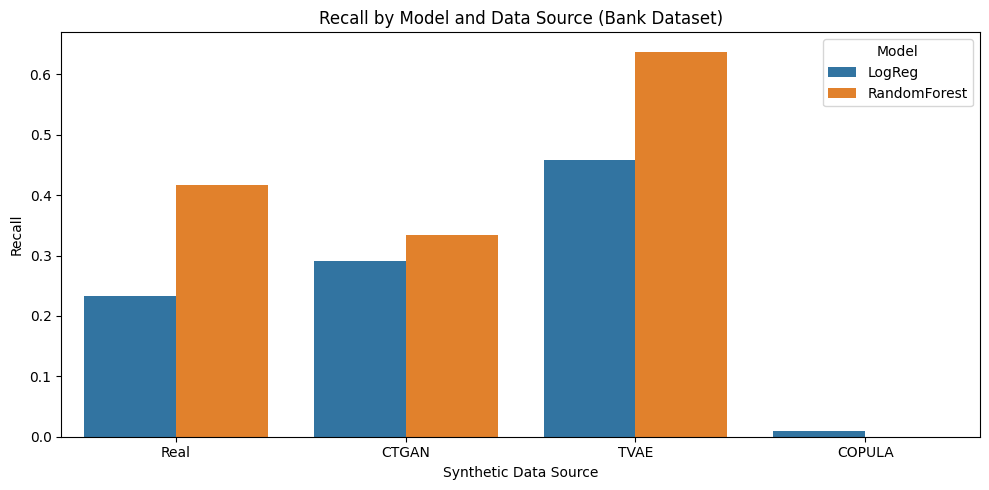

In [ ]:


import seaborn as sns

metrics = ["Accuracy", "F1", "AUC", "Precision", "Recall"]


for metric in metrics:
    plt.figure(figsize=(10, 5))
    sns.barplot(data=results_df, x="Trained_On", y=metric, hue="Model")
    plt.title(f"{metric} by Model and Data Source (Bank Dataset)")
    plt.ylabel(metric)
    plt.xlabel("Synthetic Data Source")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f"utility_{metric.lower()}_by_model_bank.png"))
    plt.show()
